In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
themes = get_themes()
set_nb_theme(themes[1])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from scipy.stats import bernoulli, ttest_ind

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,jupyterthemes

Ethen 2017-01-16 23:08:37 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.3
pandas 0.18.1
matplotlib 1.5.1
jupyterthemes 0.13.9


# The multiple hypothesis testing problem

This is simply the walkthrough of [Blog: The multiple hypothesis testing problem](http://www.claudiobellei.com/2016/10/30/multiple-testing-part1/).

Suppose a particular event has a chance of 1% of happening at the first attempt. Now, if we make $N$ attempts what is the probability that this event will have happened at least once among the $N$ attempts? The answer is $1 − 0.99^N$. For $N = 5$, the rare event already has an almost 5% chance of happening at least once in the five attempts. This is the rationale behind why multiple testings can complicate things in statistical inference.

Suppose we formulate a hypothesis test by defining a null hypothesis $H_0$ and alternative hypothesis $H_1$. We then set a type-I error level $\alpha$, which means that if the null hypothesis $H_0$ were true, we would incorrectly reject the null with probability $\alpha$. Then given $N$ tests the probability of rejecting the null in any of the tests can be written as

\begin{align}
P(\mathrm{rejecting\ the\ null\  in \ any \ of \ the \ tests}) = P(r_1 \lor r_2 \lor \dots \lor r_n)
\end{align}

In which $r_j$ denotes the event "the null is rejected at the j-th test". To compute the probability above we can convert it to:

\begin{align}
P(r_1\lor r_2\lor\dots\lor r_n) = 1 - P(r_1^* \land r_2^* \land\dots\land r_n^* ) = 1 - \prod_{j=1}^N P(r_j^*)
\end{align}

Where $r_j^*$ denotes the event "the null is NOT rejected at the j-th test".

Suppose that we do a test where we fix the type-I error $\alpha$ to 0.05 (0.05 is simply the conventionally used number). By definition, if we do one test only we will reject the null 5% of the times if the null is actually true. What if we make 2 tests? What are the chances of committing a type-I error then? The error will be:

\begin{align}
P(r_1 \lor r_2) = 1 - P(r_1^* \land r_2^*) = 1-P(r_1^*)P(r_2^*) = 1-0.95 \times 0.95 = 0.0975
\end{align}

So the consequence of doing $n$ multiple test is that the effective type-I error will become higher than expected, or to be more explicit, it will become:

$$\mathrm{Type \ I \ error} = 1-(1-\alpha)^N$$

To prevent this from happening, we can:

- In many cases, it is not even necessary to do multiple tests
- If multiple testing is unavoidable (for example, we are testing multiple hypothesis in a single test because we have multiple groups), then we can just correct the type-I error as an effective type-I error $α_{effective}$. In order to recover the original type-I error (thereby “controlling” the multiple testing), we must ensure that:

\begin{align}
1-(1-\alpha_\mathrm{effective})^N &= \alpha \ \Rightarrow \ \alpha_\mathrm{effective} = 1 - (1-\alpha)^{1/N} \approx \frac{\alpha}{N}
\end{align}

For the last part, we're assuming $\alpha\ll 1$ and using taylor expansion we can obtain $(1-x)^m \approx 1-mx$. [StackExchange](http://math.stackexchange.com/questions/210110/whats-the-name-of-the-approximation-1xn-approx-1-xn). And this goes under the name of **Bonferroni correction**.

## Example

We will draw samples from two Bernoulli distributions A and B, each with a probability $p=0.5$ of success. Each hypothesis test looks like:

\begin{eqnarray}
H_0 &:& \mu_B -\mu_A = 0 \nonumber \\
H_1 &:& \mu_B -\mu_A \neq 0 \nonumber
\end{eqnarray}

Where $\mu_A$ and $\mu_B$ are the two sample means. By our definition, the null $H_0$ is true as we are going to set both $\mu_A$ and $\mu_B$ to 0.5. The section below computes the probability of committing a type-I error as a function of the number of independent t-tests, assuming $\alpha=0.05$. 

In [3]:
# set parameters
alpha = 0.05 # Type I error rate
p1 = 0.5 # Probability for population 1
p2 = 0.5 # Probability for population 2

# simulation parameters
n_samples = 500 # number of samples each test will use
n_tests = 20 # max number of tests
n_sims = 400 # number of simulations from which to draw average

def run_exp(n_tests, n_samples, p1, p2, alpha):
    """
    simulations without Bonferroni correction, if it
    committed a Type I error in any one of the test
    return 1, else 0
    """
    for i in range(n_tests):
        testA = bernoulli(p1).rvs(n_samples)
        testB = bernoulli(p2).rvs(n_samples)
        _, pvalue = ttest_ind(testA, testB)
        if pvalue < alpha:
            return 1
    
    return 0

def run_exp_corrected(n_tests, n_samples, p1, p2, alpha):
    """simulations with Bonferroni correction"""
    for i in range(n_tests):
        testA = bernoulli(p1).rvs(n_samples)
        testB = bernoulli(p2).rvs(n_samples)
        _, pvalue = ttest_ind(testA, testB)
        if pvalue < alpha / n_tests:
            return 1
    
    return 0

In [4]:
p_rejects = []
p_rejects_corrected = []
for n_test in range(1, n_tests + 1):
    # results without using Bonferroni correction
    p_reject = [ run_exp(n_test, n_samples, p1, p2, alpha) 
                 for _ in range(n_sims) ]
    p_reject_avg = np.mean(p_reject)
    p_rejects.append(p_reject_avg)
    
    # results using Bonferroni correction
    p_reject_corrected = [ run_exp_corrected(n_test, n_samples, p1, p2, alpha) 
                           for _ in range(n_sims) ]
    p_reject_corrected_avg = np.mean(p_reject_corrected)
    p_rejects_corrected.append(p_reject_corrected_avg)

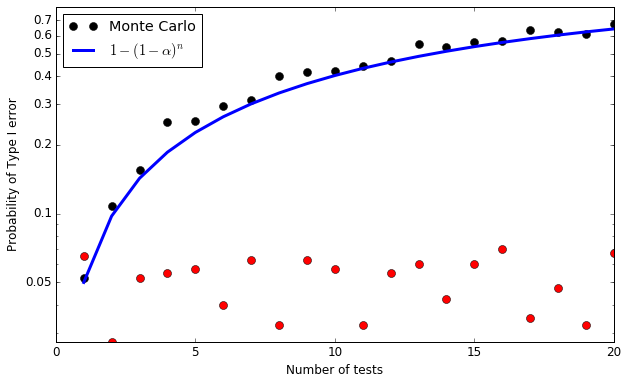

In [5]:
# change default figure size and font size
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['font.size'] = 12

# plot results
n = np.arange(1, n_tests + 1)
plt.semilogy(n, p_rejects, 'ko', markersize = 8, label = 'Monte Carlo')
plt.semilogy(n, 1 - (1 - alpha) ** n, linewidth = 3, label = r'$1-(1-\alpha)^n$')
plt.semilogy(n, p_rejects_corrected, 'ro', markersize = 8)
ticks = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
plt.yticks(ticks, ticks)
plt.ylim([0, 0.8])
plt.xlabel('Number of tests')
plt.ylabel('Probability of Type I error')
plt.legend(loc = 'best')
plt.show()

From the plot we can see, without the correcctoin, there's a rapid increase of the type-I error as the number of tests grows. Whereas applying the Bonferroni correction does succeed in controlling the error at the 5%.

## Reference

- [Blog: The multiple hypothesis testing problem](http://www.claudiobellei.com/2016/10/30/multiple-testing-part1/)